In [10]:
import os,sys,signal, copy
import math
from contextlib import contextmanager

import pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
import matplotlib.ticker as ticker
from matplotlib.animation import ArtistAnimation

from scipy.fftpack import fft
from scipy.signal.windows import hann

import musicnetRaven as musicnet

from time import time

sys.path.insert(0,'lib/')
import config
import diagnosticsP3
# import base_model

from sklearn.metrics import average_precision_score

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='3'

import torch
from torch.nn.functional import conv1d, mse_loss
from torchcontrib.optim import SWA

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
# function for returning scientific notation in a plot
def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return fr'${a} \times 10^{{{b}}}$'

In [15]:
# lvl1 convolutions are shared between regions
m = 128
k = 500              # lvl1 nodes
n_fft = 4096              # lvl1 receptive field
window = 16384 # total number of audio samples?
stride = 512
batch_size = 500
regions = 1 + (window - n_fft)//stride

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers
kwargs = {'num_workers': 2, 'pin_memory': True, 'worker_init_fn': worker_init}

In [16]:
start = time()
root = '../data/'
train_set = musicnet.MusicNet(root=root
                              ,train=True, download=True, 
                              window=window, mmap=False)#, pitch_shift=5, jitter=.1)
test_set = musicnet.MusicNet(root=root, train=False, window=window, epoch_size=50000, mmap=False)
print("Time used = ", time()-start)

Time used =  28.281855583190918


In [17]:
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

In [18]:
def create_filters(n_fft, freq_bins=None, low=50,high=6000, mode="fft"):
    if freq_bins==None:
        freq_bins = n_fft//2+1
    
    s = np.arange(0, n_fft, 1)
    wsin = np.empty((freq_bins,1,n_fft), dtype=np.float32)
    wcos = np.empty((freq_bins,1,n_fft), dtype=np.float32)
    start_freq = low
    end_freq = high
    # num_cycles = start_freq*d/44000.
    # scaling_ind = np.log(end_freq/start_freq)/k
    
    if mode=="fft":
        window_mask = 1
    elif mode=="stft":
        window_mask = hann(n_fft, sym=False) # same as 0.5-0.5*np.cos(2*np.pi*x/(k))
    else:
        raise Exception("Unknown mode, please chooes either \"stft\" or \"fft\"")
        

    for k in range(freq_bins): # Only half of the bins contain useful info
        wsin[k,0,:] = window_mask*np.sin(2*np.pi*k*s/n_fft)
        wcos[k,0,:] = window_mask*np.cos(2*np.pi*k*s/n_fft)
    
    return wsin,wcos

def create_filtersv2(n_fft, freq_bins=None, low=50,high=6000, mode="fft"):
    if freq_bins==None:
        freq_bins = n_fft//2+1
    
    s = torch.arange(0, n_fft, 1.)
    wsin = torch.empty((freq_bins,1,n_fft))
    wcos = torch.empty((freq_bins,1,n_fft))
    start_freq = low
    end_freq = high
    # num_cycles = start_freq*d/44000.
    # scaling_ind = np.log(end_freq/start_freq)/k
    
    if mode=="fft":
        window_mask = 1
    elif mode=="stft":
        window_mask = 0.5-0.5*torch.cos(2*math.pi*s/(n_fft)) # same as hann(n_fft, sym=False)
    else:
        raise Exception("Unknown mode, please chooes either \"stft\" or \"fft\"")
        

    for k in range(freq_bins): # Only half of the bins contain useful info
        wsin[k,0,:] = window_mask*torch.sin(2*math.pi*k*s/n_fft)
        wcos[k,0,:] = window_mask*torch.cos(2*math.pi*k*s/n_fft)
    
    return wsin,wcos


In [19]:
L = torch.nn.MSELoss()

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, avg=.9998):
        super(Model, self).__init__()
        # Create filter windows
        wsin, wcos = create_filtersv2(n_fft,k, mode="stft")
        with torch.cuda.device(0):
            self.wsin = torch.Tensor(wsin).cuda()
            self.wcos = torch.Tensor(wcos).cuda()
            
        # Creating Layers
        self.linear = torch.nn.Linear(regions*k, m)
        torch.nn.init.constant_(self.linear.weight, 0) # initialize
        
        self.avg = avg
        #Create a container for weight average
        self.averages = copy.deepcopy(list(parm.cuda().data for parm in self.parameters())) 

        
    def forward(self,x):
        zx = conv1d(x[:,None,:], self.wsin, stride=stride).pow(2) \
           + conv1d(x[:,None,:], self.wcos, stride=stride).pow(2)
        return self.linear(torch.log(zx + 10e-8).view(x.data.size()[0],regions*k))
    
    def average_iterates(self):
        for parm, pavg in zip(self.parameters(), self.averages):
            pavg.mul_(self.avg).add_(1.-self.avg, parm.data) # 0.9W_avg + 0.1W_this_ite
    
    
@contextmanager
def averages(model):
    orig_parms = copy.deepcopy(list(parm.data for parm in model.parameters()))
    for parm, pavg in zip(model.parameters(), model.averages):
        parm.data.copy_(pavg)
    yield
    for parm, orig in zip(model.parameters(), orig_parms):
        parm.data.copy_(orig)

# No Average 

In [ ]:
model = Model()
model.cuda()
loss_history = []
avgp_history = []

avg = .9998
epochs = 20
optimizer = torch.optim.SGD(model.parameters(), lr=0.000001, momentum=.95)
# optimizer = SWA(base_opt, swa_start=0, swa_freq=1, swa_lr=0.000001)

try:
    with train_set, test_set:
        total_i = len(train_loader)
        print("squre loss\tavg prec\ttime\t\tutime")
        for e in range(epochs):
            t = time()
            # Training
            for i, (x,y) in enumerate(train_loader):
                print(f"{i}/{total_i} batches", end = '\r')
                optimizer.zero_grad()
                
                # making x and y into pytorch dealable format
                x = x.cuda(non_blocking=True)
                y = y.cuda(non_blocking=True)
                
                loss = L(model(x),y)
                loss.backward()
                optimizer.step()
                
#                 model.average_iterates() # Averaging the weights for validation
                
            t1 = time()
            avgp, loss = 0.,0.           
#             optimizer.swap_swa_sgd() # change to average weight
            
            # Testing
            
#             with averages(model):
            for i, (x_test,y_test) in enumerate(test_loader):
                x_test = x_test.cuda()
                y_test = y_test.cuda()
                yhatvar = model(x_test)
                loss += L(yhatvar, y_test).item() #getting the number
                
                yground = y_test.data.cpu().numpy()
                yhat = yhatvar.data.cpu().numpy()
            avgp = average_precision_score(yground.flatten(),yhat.flatten())
            loss_history.append(loss/len(test_loader))
            avgp_history.append(avgp)
            print('{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(loss_history[-1],avgp_history[-1],time()-t, time()-t1))


        
except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print("Finsihed")
    
no_average_loss_history = loss_history
no_average_avgp_history = avgp_history

squre loss	avg prec	time		utime


# Averaged Weights

In [76]:
model = Model()
model.cuda()
loss_history = []
avgp_history = []

avg = .9998
optimizer = torch.optim.SGD(model.parameters(), lr=0.000001, momentum=.95)
# optimizer = SWA(base_opt, swa_start=0, swa_freq=1, swa_lr=0.000001)

try:
    with train_set, test_set:
        total_i = len(train_loader)
        print("squre loss\tavg prec\ttime\t\tutime")
        for e in range(epochs):
            t = time()
            for i, (x,y) in enumerate(train_loader):
                print(f"{i}/{total_i} batches", end = '\r')
                optimizer.zero_grad()
                
                # making x and y into pytorch dealable format
                x = x.cuda(non_blocking=True)
                y = y.cuda(non_blocking=True)
                
                loss = L(model(x),y)
                loss.backward()
                optimizer.step()
                
                model.average_iterates() # Averaging the weights for validation
                
            t1 = time()
            avgp, loss = 0.,0.           
#             optimizer.swap_swa_sgd() # change to average weight
            
            # For testing
            yground = torch.FloatTensor(batch_size*len(test_loader), m) # what not do this together with loss
            yhat = torch.FloatTensor(batch_size*len(test_loader), m)
            
            with averages(model):
                for i, (x_test,y_test) in enumerate(test_loader):
                    x_test = x_test.cuda()
                    y_test = y_test.cuda()
                    yhatvar = model(x_test)
                    loss += L(yhatvar, y_test).item() #getting the number

                    yground = y_test.data.cpu().numpy()
                    yhat = yhatvar.data.cpu().numpy()
                avgp = average_precision_score(yground.flatten(),yhat.flatten())
                loss_history.append(loss/len(test_loader))
                avgp_history.append(avgp)
                print('{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(loss_history[-1],avgp_history[-1],time()-t, time()-t1))


        
except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print("Finsihed")
    
average_loss_history = loss_history
average_avgp_history = avgp_history

squre loss	avg prec	time		utime
0.017608	0.039619	9.085154	3.510149
0.017358	0.089775	8.956689	3.507010
0.017280	0.134385	9.089458	3.557616
0.017236	0.174205	9.045632	3.567029
0.016995	0.252768	9.021455	3.497863
0.016877	0.302403	8.869556	3.420219
0.016717	0.377225	9.087731	3.596801
0.016593	0.388041	8.985042	3.506407
0.016370	0.444503	9.008216	3.535949
0.016192	0.412392	8.963685	3.512444
0.015974	0.429002	8.953453	3.575049
0.015925	0.403374	8.965661	3.506057
0.015820	0.454019	9.023885	3.534521
0.015665	0.455687	9.050569	3.440142
0.015382	0.478538	9.090491	3.604926
0.015355	0.444998	9.098167	3.575477
0.015185	0.471404	9.066603	3.587163
0.015048	0.511549	9.038618	3.560881
0.014860	0.459836	9.066704	3.569780
0.014797	0.455355	9.035859	3.577923
Finsihed


In [77]:
W_old = model.linear.weight

In [81]:
model = Model()
model.cuda()
loss_history = []
avgp_history = []

avg = .9998
base_opt = torch.optim.SGD(model.parameters(), lr=0.000001, momentum=.95)
optimizer = SWA(base_opt, swa_start=0, swa_freq=9, swa_lr=0.000001)

try:
    with train_set, test_set:
        total_i = len(train_loader)
        print("squre loss\tavg prec\ttime\t\tutime")
        for e in range(epochs):
            t = time()
            for i, (x,y) in enumerate(train_loader):
                print(f"{i}/{total_i} batches", end = '\r')
                optimizer.zero_grad()
                
                # making x and y into pytorch dealable format
                x = x.cuda(non_blocking=True)
                y = y.cuda(non_blocking=True)
                
                loss = L(model(x),y)
                loss.backward()
                optimizer.step()
                
                
            t1 = time()
            avgp, loss = 0.,0.           
#             optimizer.swap_swa_sgd() # change to average weight
            
            # For testing
            yground = torch.FloatTensor(batch_size*len(test_loader), m) # what not do this together with loss
            yhat = torch.FloatTensor(batch_size*len(test_loader), m)
            
            
            optimizer.swap_swa_sgd() # Using the running average weight
            for i, (x_test,y_test) in enumerate(test_loader):
                x_test = x_test.cuda()
                y_test = y_test.cuda()
                yhatvar = model(x_test)
                loss += L(yhatvar, y_test).item() #getting the number

                yground = y_test.data.cpu().numpy()
                yhat = yhatvar.data.cpu().numpy()
            avgp = average_precision_score(yground.flatten(),yhat.flatten())
            loss_history.append(loss/len(test_loader))
            avgp_history.append(avgp)
            optimizer.swap_swa_sgd()  # Swap back the normal weight
            print('{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(loss_history[-1],avgp_history[-1],time()-t, time()-t1))


        
except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print("Finsihed")
    
polyak_loss_history = loss_history
polyak_avgp_history = avgp_history

squre loss	avg prec	time		utime
0.016488	0.099942	9.092021	3.535851
0.016290	0.144524	9.055837	3.542352
0.015933	0.234565	9.160381	3.604075
0.015704	0.238341	8.978658	3.544090
0.015554	0.315938	8.961053	3.492199
0.015323	0.357227	9.015105	3.528798
0.015142	0.355992	8.984607	3.481203
0.015037	0.360337	9.087263	3.549439
0.014849	0.401641	8.975298	3.544090
0.014693	0.420365	9.063250	3.559409
0.014542	0.403289	8.981805	3.561174
0.014464	0.376769	8.945800	3.537397
0.014334	0.422115	9.058784	3.517835
0.014327	0.422323	9.023718	3.547756
0.014188	0.456731	8.983289	3.496498
0.014130	0.433514	9.042904	3.553344
0.014003	0.431594	8.946251	3.570506
0.013955	0.432499	8.950424	3.517100
0.013828	0.417979	9.030600	3.573377
0.013790	0.441022	8.986912	3.548510
Finsihed


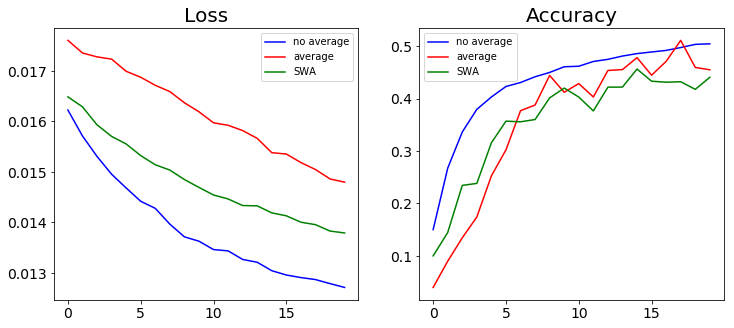

In [83]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(no_average_loss_history, 'b')
ax[0].plot(average_loss_history,'r')
ax[0].plot(polyak_loss_history,'g')
ax[0].set_title('Loss', size=20)
ax[0].tick_params('both', labelsize=14)
ax[0].legend(['no average', 'average', 'SWA'])


ax[1].plot(no_average_avgp_history, 'b')
ax[1].plot(average_avgp_history, 'r')
ax[1].plot(polyak_avgp_history, 'g')
ax[1].set_title('Accuracy', size=20)
ax[1].tick_params('both', labelsize=14)
ax[1].legend(['no average', 'average', 'SWA'])

# Mirex stats

In [88]:
config.test_ids

(2303, 2382, 1819)

In [87]:
mse_test, Yhat, Y, mse_breakdown, avp_breakdown = model.sample_records(config.test_ids, 7500, fixed_stride=512)
avp_test = average_precision_score(Y.flatten(),Yhat.flatten())
print(avp_test)

AttributeError: 'Model' object has no attribute 'sample_records'

In [8]:
Accavg = Etotavg = 0
for i in range(3):
    _,_,_,Acc,Etot = visuals.mirex_statistics(model,i,threshold=.4)
    Accavg += Acc
    Etotavg += Etot

print Accavg/3.,Etotavg/3.

AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
41.71	63.06	22.18	0.20	0.80	0.11	0.67	0.02
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
26.08	45.29	10.12	0.09	0.95	0.07	0.83	0.05
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
47.68	64.24	21.16	0.19	0.83	0.07	0.71	0.04
0.158590506342 0.860359774327


# Extended test set stats

In [7]:
mse_test, Yhat, Y, mse_breakdown, avp_breakdown = model.sample_records(config.test_ids_ext, 7500, fixed_stride=512)
avp_test = average_precision_score(Y.flatten(),Yhat.flatten())
print avp_test

0.404689218856


In [15]:
Accavg = Etotavg = 0
for i in range(10):
    _,_,_,Acc,Etot = diagnostics.mirex_statistics(model,i,threshold=.4)
    Accavg += Acc
    Etotavg += Etot

print Accavg/10.,Etotavg/10.

AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
41.75	63.06	22.18	0.20	0.80	0.11	0.67	0.02
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
26.16	45.09	10.12	0.09	0.95	0.07	0.83	0.05
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
47.70	63.96	21.19	0.19	0.83	0.07	0.71	0.04
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
31.72	34.74	31.58	0.20	0.90	0.38	0.31	0.22
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
44.54	54.91	30.48	0.24	0.78	0.16	0.53	0.09
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
45.55	67.25	18.61	0.17	0.83	0.08	0.74	0.01
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
40.71	54.03	29.58	0.24	0.84	0.11	0.59	0.14
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
44.91	65.45	18.29	0.17	0.85	0.06	0.75	0.03
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
47.26	64.15	16.07	0.15	0.86	0.07	0.77	0.02
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
35.24	50.46	11.62	0.10	0.90	0.10	0.78	0.01
0.174316824517 0.854800543932
